102/102 [==============================] - 2s 20ms/step
2.712310267429726


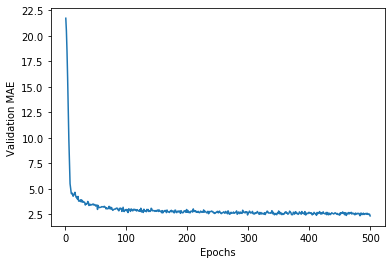

In [0]:
from keras.datasets import boston_housing
from keras import models
from keras import layers
from keras import optimizers
import matplotlib.pyplot as plt
import numpy as np

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

#We do a feature-wise normalization by substracting the mean to the data and dividing by the std deviation
mean = train_data.mean(0)#We obtain the mean of each feature for all the samples. 
train_data -= mean# We subtract for each feature of all the samples their mean by broadcasting 
std = train_data.std(axis = 0)#We obtain the std deviation of each feature for all the samples
train_data /= std# We divide each feature of all the samples by their std deviation by broadcasting 

test_data -= mean
test_data /= std
num_epochs = 500
#We build up the nn architecture. We create a function as we are going to implement a k-fold validation, which requires 
#to instantiate the same model multiple times
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='elu',input_shape=(train_data.shape[1])))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(128, activation='elu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(1))

  #We use the mean squared error, the square of the diff between the predictions and the targets, as loss function
  #We use the mean absolute error, the absolute value of the difference between the prediction and the targets, as the metric
  model.compile(optimizer=optimizers.RMSprop(decay = 0.03/num_epochs), loss='mse', metrics=['mae'])
  return model

#We implement the k-fold validation algorithm, which is used when we have a low number of samples. It consists
#in creating k partitions(typically 4 or 5), then instantiating K identical models and training each one on k-1 partitions while 
#evaluating on the remaining partition. The final validation score used is then the average of the k validation scores obtained.
"""k = 4
num_val_samples = len(train_data) // k#Integral division and discarding remainder
all_mae_histories = []
all_val_mae_histories = []

for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

  partial_train_data = np.concatenate([train_data[:i * num_val_samples],train_data[(i + 1) * num_val_samples:]],axis=0)
  partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],train_targets[(i + 1) * num_val_samples:]],axis=0)

  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=16,validation_data=(val_data, val_targets), verbose=0)
  #print(history.history.keys())
  mae_history = history.history['mean_absolute_error']
  val_mae_history = history.history['val_mean_absolute_error']
  all_mae_histories.append(mae_history)
  all_val_mae_histories.append(val_mae_history)
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
average_val_mae_history = [np.mean([x[i] for x in all_val_mae_histories]) for i in range(num_epochs)]
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])
smooth_val_mae_history = smooth_curve(average_val_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_val_mae_history)
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(['Training MAE','Validation MAE'])
plt.show()"""

#After we set the best parameters using the k-fold validation algorithm, we can train the final nn with all of the training data

model = build_model()
history = model.fit(train_data, train_targets, epochs=num_epochs, batch_size=16, verbose=0)
train_mae_score = history.history['mean_absolute_error']
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print(test_mae_score)
plt.plot(range(1, len(train_mae_score) + 1),train_mae_score)
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()